# Sample slices from a image stack
- Uniform sampling from paritions of a given image stack 
- This should help generate balanced / region-matched samples from case and control groups

### Imports

In [2]:
import sys
import os
from glob import glob
import napari
import pydicom
import zarr
import numpy as np
import pandas as pd
import random
import skimage
from skimage.filters import threshold_otsu
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')
from lib.io_utils import *
from lib.sampling_utils import *


### Paths

In [3]:
data_dir = '/Users/nikhil/Downloads/'
img_dir = data_dir + 'Series-2/'

### Read a sample dicom

In [4]:
img3d = read_diacom_stack(img_dir)

glob: /Users/nikhil/Downloads/Series-2/
file count: 84
skipped, no SliceLocation: 0
CT stack shape: (512, 512, 84)


### view 2d slices

Text(0.5, 1.0, 'sample binarization')

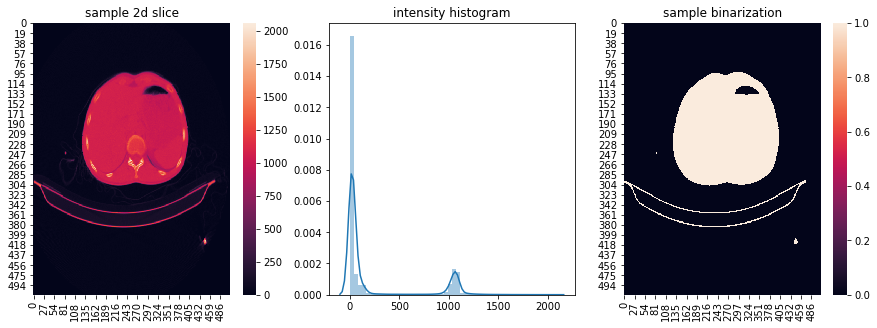

In [5]:
slice_id = 15
img2d = img3d[:,:,slice_id]

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
ax = axes[0]
g = sns.heatmap(img2d,ax=ax)
ax.set_title('sample 2d slice')

ax = axes[1]
g = sns.distplot(img2d.ravel(),ax=ax)
ax.set_title('intensity histogram')

# sample binary slice
thresh = threshold_otsu(img2d)
binary = img2d > thresh

ax = axes[2]
g = sns.heatmap(binary,ax=ax)
ax.set_title('sample binarization')

### Threshold, binarize, and find peaks

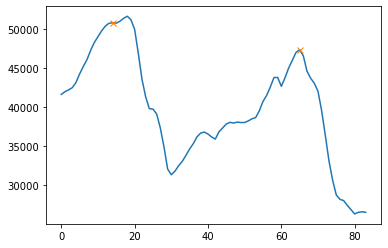

In [6]:
slice_sum, lung_endpoints = get_lung_location(img3d)
plt.plot(slice_sum)
plt.plot(lung_endpoints, slice_sum[lung_endpoints], "x")

### Napari 3d views

In [7]:
with napari.gui_qt():
    viewer = napari.view_image(img3d)

### Pick slice samples
- Sampling is designed to provide slices from 'similar' lung locations for case and control groups
- Process: 
    - We first divide lung into N partitions (e.g. top,middle,bottom)
    - We then sample same number of slices from each partition for a given CT image and a given group 

In [8]:
# example: 
CT_endpoints = {1:[10,100],2:[25,75]}
n_CT_partitions = 4
n_samples_per_scan = 10

get_slice_locations(CT_endpoints,n_CT_partitions,n_samples_per_scan)

Number of CT scans 2, CT_partitions: 4, samples per scan: 10,    n_samples_per_CT_partitions: 2


,CT_id,partition_id,slice_ids
0,1,0,"[25, 12]"
1,1,1,"[34, 41]"
2,1,2,"[69, 74]"
3,1,3,"[96, 97]"
0,2,0,"[32, 26]"
1,2,1,"[38, 42]"
2,2,2,"[62, 57]"
3,2,3,"[72, 74]"


## Do a batch run (i.e. multiple CT scans)

In [9]:
scan_subdir_list = ['Series-2','Series-3']

CT_endpoints = {}
CT_slice_sums = {}
CT_df = pd.DataFrame(columns=['total_slices','lung_slices','endpoints'])

# Generate endpoints for all scanes
for scan_subdir in scan_subdir_list:
    print('\nscan subdir: {}'.format(scan_subdir))
    img_dir = '{}{}/'.format(data_dir,scan_subdir)
    img3d = read_diacom_stack(img_dir)
    print('Finding lung slices endpoints')
    slice_sum, lung_endpoints = get_lung_location(img3d)
    n_lung_slices = lung_endpoints[1]-lung_endpoints[0]
    print('number of lung slices: {}'.format(n_lung_slices))
    CT_endpoints[scan_subdir] = lung_endpoints
    CT_slice_sums[scan_subdir] = slice_sum
    CT_df.loc[scan_subdir] = [img3d.shape[2],n_lung_slices,lung_endpoints]
    
    
# Generate endpoints for all scanes
n_CT_partitions = 4
n_samples_per_scan = 12 #try to keep this multiple of n_CT_partitions
slice_loc_df = get_slice_locations(CT_endpoints,n_CT_partitions,n_samples_per_scan)

slice_loc_df


scan subdir: Series-2
glob: /Users/nikhil/Downloads/Series-2/
file count: 84
skipped, no SliceLocation: 0
CT stack shape: (512, 512, 84)
Finding lung slices endpoints
number of lung slices: 51

scan subdir: Series-3
glob: /Users/nikhil/Downloads/Series-3/
file count: 419
skipped, no SliceLocation: 0
CT stack shape: (512, 512, 419)
Finding lung slices endpoints
number of lung slices: 255
Number of CT scans 2, CT_partitions: 4, samples per scan: 12,    n_samples_per_CT_partitions: 3


,CT_id,partition_id,slice_ids
0,Series-2,0,"[21, 15, 14]"
1,Series-2,1,"[31, 38, 33]"
2,Series-2,2,"[49, 52, 51]"
3,Series-2,3,"[61, 58, 59]"
0,Series-3,0,"[131, 78, 73]"
1,Series-3,1,"[166, 186, 173]"
2,Series-3,2,"[251, 228, 237]"
3,Series-3,3,"[321, 303, 299]"
